In [ ]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.feature as skf
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
from skimage import measure
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from scipy.stats import mode
import pandas as pd
from scipy.special import expit
from sklearn import metrics
from skimage.feature import hog

In [ ]:
# preprocess_image

target_size = (256, 256)

def pad_image(image):
    h, w = image.shape
    pad_h_top = max(0, (target_size[0] - h) // 2)
    pad_h_bottom = max(0, target_size[0] - h - pad_h_top)
    pad_w_left = max(0, (target_size[1] - w) // 2)
    pad_w_right = max(0, target_size[1] - w - pad_w_left)

    padded_image = np.pad(image, ((pad_h_top, pad_h_bottom), (pad_w_left, pad_w_right)), mode='constant', constant_values = 0)
    return padded_image[:target_size[0], :target_size[1]]  # Ensure final dimensions


def resize_image(image):
    h, w = image.shape
    scale = min(target_size[0] / float(h), target_size[1] / float(w))
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv.resize(image, (new_w, new_h))

    return resized_image


def apply_otsu_threshold(image):
    blurred_image = cv.GaussianBlur(image, (5, 5), 0)
    _, thresholded_image = cv.threshold(blurred_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Morphological operations to clean up small artifacts
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    cleaned_image = cv.morphologyEx(thresholded_image, cv.MORPH_CLOSE, kernel)
    cleaned_image = cv.morphologyEx(cleaned_image, cv.MORPH_OPEN, kernel)

    return cleaned_image


def apply_clahe(image):
    # Apply CLAHE to enhance the contrast of the image.
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)  # Apply CLAHE to the grayscale image

    return clahe_image


def normalize_image(image):
    min_val, max_val = np.min(image), np.max(image)
    return (image - min_val) / (max_val - min_val)


def skull_strip(image, thresholded_image):
    # Use the thresholded image as a mask to keep only the brain region
    mask = thresholded_image > 0
    skull_stripped_image = np.zeros_like(image)
    skull_stripped_image[mask] = image[mask]
    return skull_stripped_image


def preprocess_image(image):
    if image.shape[0] < target_size[0] or image.shape[1] < target_size[1]:
        padded_image = pad_image(image)
    else:
        resized_image = resize_image(image)
        padded_image = pad_image(resized_image)

    # Apply CLAHE for contrast enhancement
    clahe_image = apply_clahe(padded_image)  # Assuming CLAHE function is already defined

    # Apply Otsu thresholding to isolate the brain region
    otsu_image = apply_otsu_threshold(clahe_image)
    # Perform skull stripping
    skull_stripped_image = skull_strip(clahe_image, otsu_image)

    # Normalize the image to [0, 1]
    normalized_image = normalize_image(skull_stripped_image)  # Normalize function defined as before

    return normalized_image


def preprocess_image_2(image):
    if image.shape[0] < target_size[0] or image.shape[1] < target_size[1]:
        padded_image = pad_image(image)
    else:
        resized_image = resize_image(image)
        padded_image = pad_image(resized_image)

    clahe_image = apply_clahe(padded_image)
    otsu_image = apply_otsu_threshold(clahe_image)
    skull_stripped_image = skull_strip(clahe_image, otsu_image)
    normalized_image = normalize_image(skull_stripped_image)

    return padded_image, clahe_image, otsu_image, skull_stripped_image, normalized_image

In [ ]:
# prepare_images

def rename_image(file_name, input_dir, index):
    if 'no' in input_dir:
        return f"no_{index}.png"
    elif 'yes' in input_dir:
        return f"yes_{index}.png"
    else:
        return f"image_{index}.png"

def prepare_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    index = 1

    for file_name in os.listdir(input_dir):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_dir, file_name)
            image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

            processed_image = preprocess_image(image)
            new_name = rename_image(file_name, input_dir, index)
            output_path = os.path.join(output_dir, new_name)

            cv.imwrite(output_path, (processed_image * 255).astype(np.uint8))
            index += 1

In [ ]:
def visualize_steps(original, padded, clahe, otsu, stripped, normalized):
    titles = ['Original', 'Padded', 'CLAHE', 'Otsu Threshold', 'Skull Stripped', 'Normalized']
    images = [original, padded, clahe, otsu, stripped, normalized]

    plt.figure(figsize=(15, 5))
    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 6, i + 1)
        plt.title(title)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_directory_images(input_dir, num_images=5):
    # Load and preprocess images
    for i, file_name in enumerate(os.listdir(input_dir)):
        if file_name.endswith(('.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG')) and i < num_images:
            img_path = os.path.join(input_dir, file_name)
            image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

            # Preprocess image
            padded_image, clahe_image, otsu_image, skull_stripped_image, roi, normalized_image = preprocess_image_2(image)

            # Resize original image for visualization
            resized_original_image = cv.resize(image, target_size)

            # Visualize all steps
            visualize_steps(padded_image, clahe_image, otsu_image, skull_stripped_image, roi, normalized_image)

In [ ]:
input_dir_no = '/content/drive/MyDrive/my_dataset/no'         # Path to "no" images
output_dir_no = '/content/drive/MyDrive/my_dataset/no_after'  # Path to store processed "no" images

prepare_images(input_dir_no, output_dir_no)

In [ ]:
input_dir_yes = '/content/drive/MyDrive/my_dataset/yes'         # Path to "yes" images
output_dir_yes = '/content/drive/MyDrive/my_dataset/yes_after'  # Path to store processed "yes" images

prepare_images(input_dir_yes, output_dir_yes)

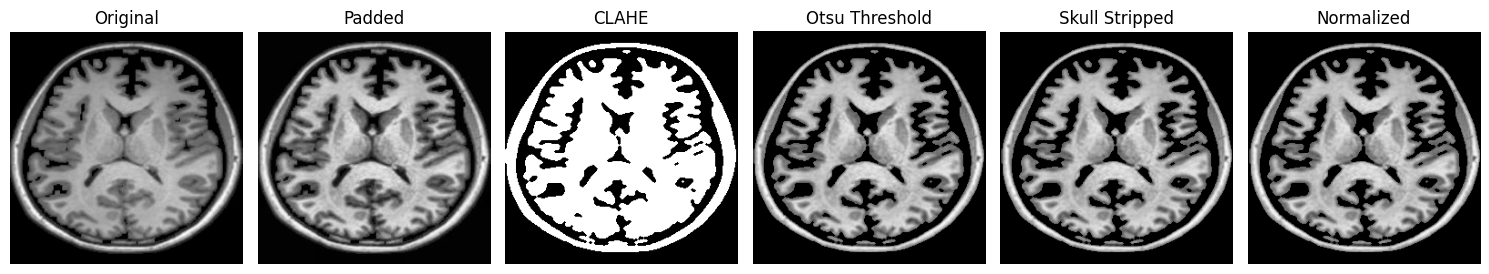

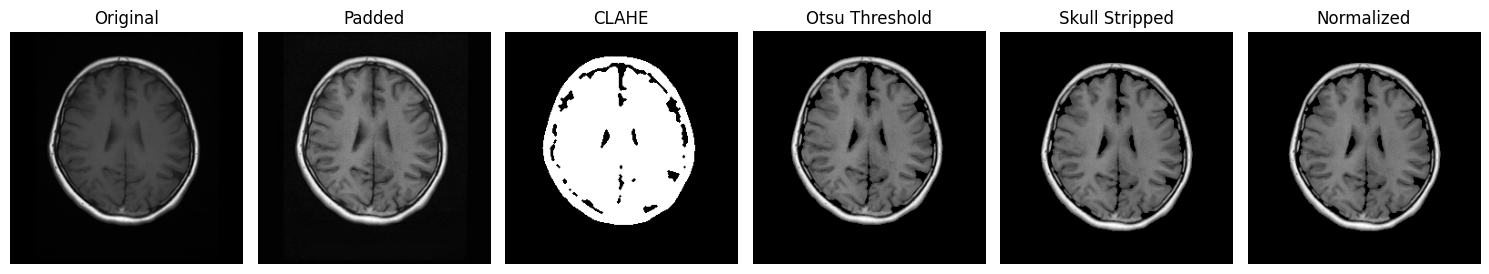

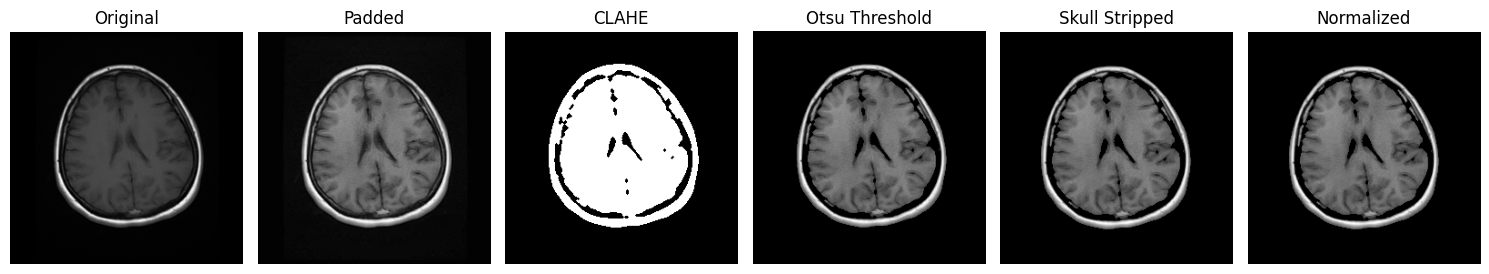

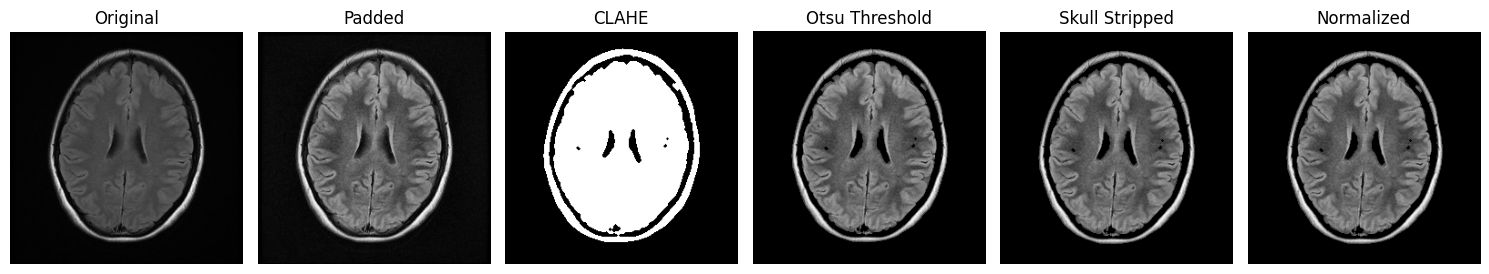

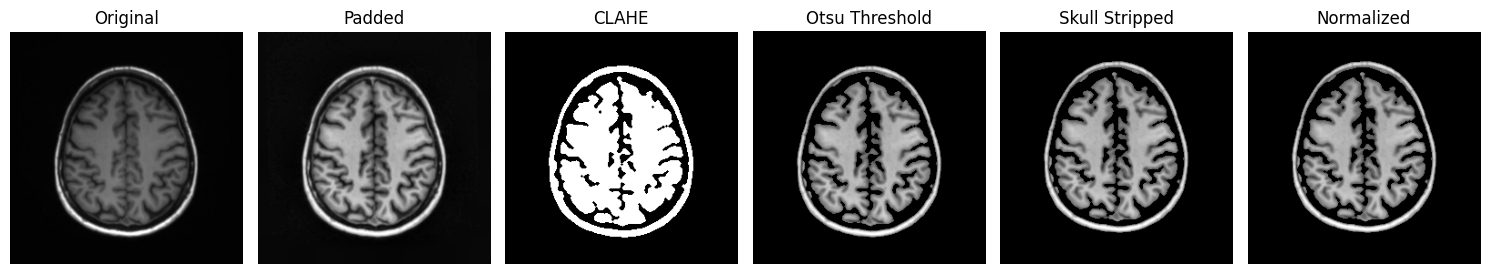

In [ ]:
input_dir = "/content/drive/MyDrive/my_dataset/no"
visualize_directory_images(input_dir)

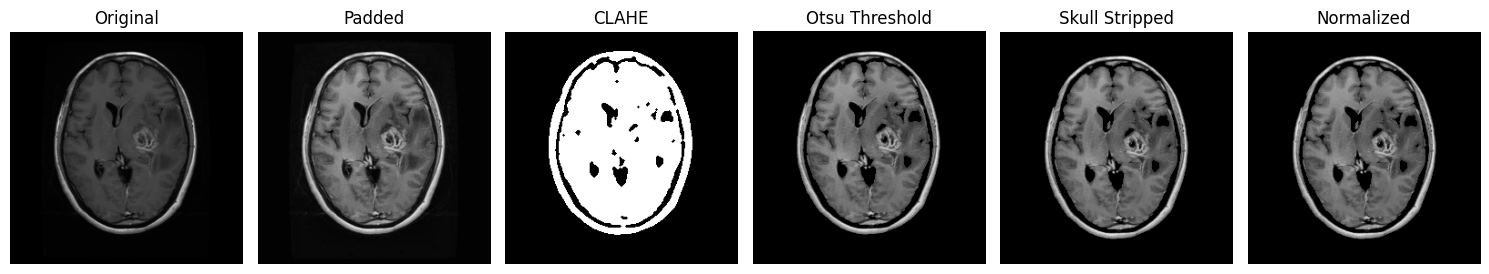

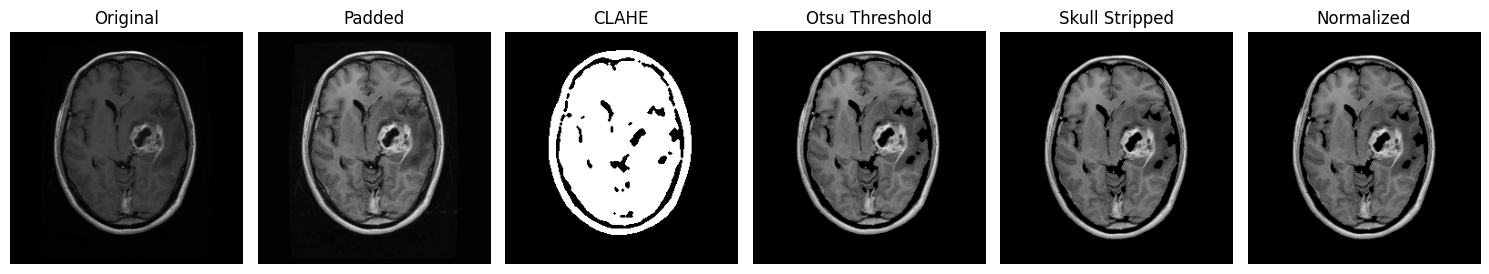

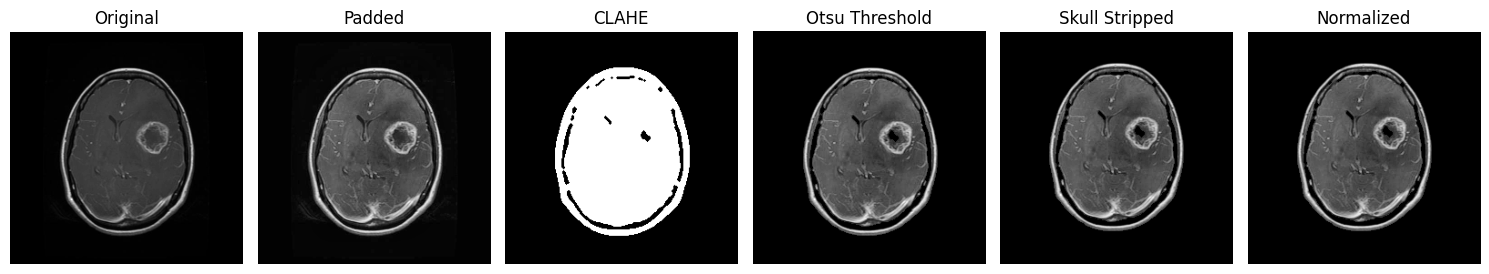

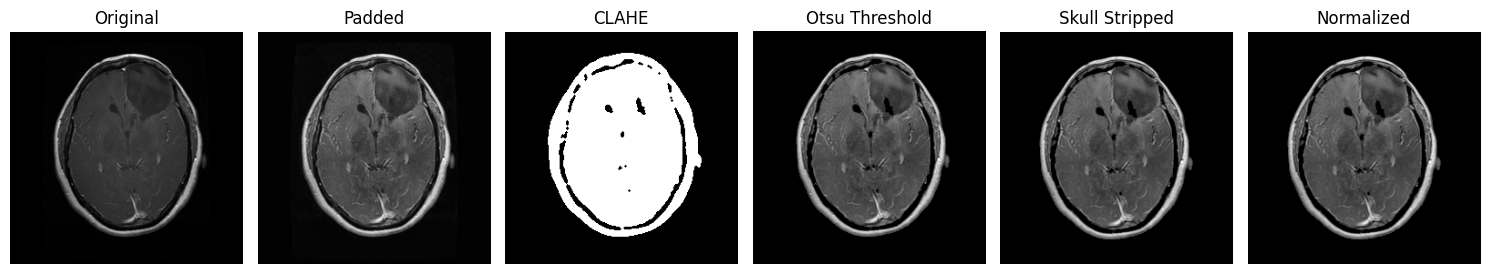

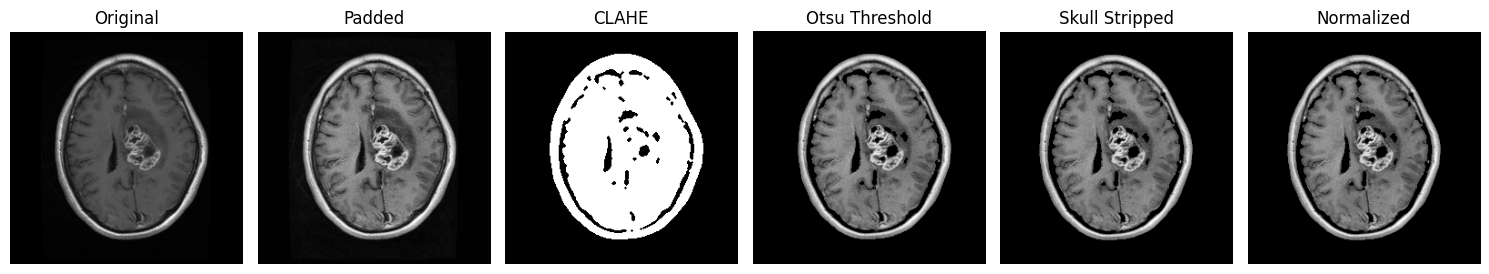

In [ ]:
input_dir = "/content/drive/MyDrive/my_dataset/yes"
visualize_directory_images(input_dir)

In [ ]:
def extract_glcm_features(input_dir):
    glcm_features = []
    for img_name in os.listdir(input_dir):
        if img_name.endswith('.png'):  # Ensure only processing PNG files
            img_path = os.path.join(input_dir, img_name)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)  # Read image in grayscale

            # Compute GLCM features
            glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')
            correlation = graycoprops(glcm, 'correlation')
            energy = graycoprops(glcm, 'energy')
            homogeneity = graycoprops(glcm, 'homogeneity')

            # Flatten and combine features
            features = np.hstack([contrast.flatten(), correlation.flatten(), energy.flatten(), homogeneity.flatten()])
            glcm_features.append(features)

    return np.array(glcm_features)


def extract_hog(input_dir):
    hog_features = []
    for img_name in os.listdir(input_dir):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_dir, img_name)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)  # Read image in grayscale
            features = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                feature_vector=True
            )
            hog_features.append(features)
    return np.array(hog_features)

In [ ]:
input_dir_no = '/content/drive/MyDrive/my_dataset/no_after'
input_dir_yes = '/content/drive/MyDrive/my_dataset/yes_after'

# Initialize empty lists to store features
features_no_GLCM = extract_glcm_features(input_dir_no)
features_yes_GLCM = extract_glcm_features(input_dir_yes)

features_no_HOG = extract_hog(input_dir_no)
features_yes_HOG = extract_hog(input_dir_yes)

In [ ]:
compined_features_no = np.concatenate((features_no_GLCM, features_no_HOG), axis=1)
compined_features_yes = np.concatenate((features_yes_GLCM, features_yes_HOG), axis=1)

# Step 1: Combine the data
features = np.concatenate((compined_features_no, compined_features_yes), axis=0)
# Step 2: Create labels (1 for "yes", 0 for "no")
labels = np.concatenate((np.ones(len(compined_features_yes)), np.zeros(len(compined_features_no))), axis=0)

In [ ]:
# Split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 4: Normalize the data
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)


# Convert your feature data into a pandas DataFrame
df1 = pd.DataFrame(x_train_normalized)
df2 = pd.DataFrame(x_test_normalized)
# Remove constant columns
idxs = (df1 != df1.iloc[0]).any()
df1 = df1.loc[:, idxs]
df2 = df2.loc[:, idxs]

# Convert back to a NumPy array
x_train_normalized = df1.to_numpy()
x_test_normalized = df2.to_numpy()

In [ ]:
n_features = x_train_normalized.shape
print(f"Number of features train: {n_features}")

n_features = x_test_normalized.shape
print(f"Number of features test: {n_features}")

Number of features train: (160, 31320)
Number of features test: (40, 31320)


In [ ]:
# Feature Selection (SelectKBest)
selector = SelectKBest(score_func=f_classif, k = 10)
x_train_reduced = selector.fit_transform(x_train_normalized, y_train)  # Fit and transform training data
x_test_reduced = selector.transform(x_test_normalized)

In [ ]:
n_features = x_train_reduced.shape
print(f"Number of features train: {n_features}")

n_features = x_test_reduced.shape
print(f"Number of features test: {n_features}")

Number of features train: (160, 10)
Number of features test: (40, 10)


In [ ]:
# Initialize SVM
svm = SVC(probability=True)

# Create a Stratified K-Fold object with shuffle=False
cvfolds = StratifiedKFold(n_splits=5, shuffle=False)  # Stratified K-Fold cross-validation

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svm, x_train_reduced, y_train, cv=cvfolds)  # Cross-validation on training set

# Print the cross-validation scores and average
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.84375 0.84375 0.75    0.84375 0.78125]
Average cross-validation score: 0.8125


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 0.01, 0.05, 0.3, 0.2],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 0.01],
    'degree': [2, 3, 4, 5],
    'class_weight': [{0: 1, 1: w} for w in [2, 3, 5, 10]],
}

# Set up GridSearchCV with the updated parameter grid
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cvfolds, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(x_train_reduced, y_train)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score: 0.8375


In [ ]:
### print classification report for train data
y_pred_train = grid_search.predict(x_train_reduced)
class_report_train = classification_report(y_train, y_pred_train)
print("Train Classification Report:")
print(class_report_train)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81        81
         1.0       0.77      0.92      0.84        79

    accuracy                           0.82       160
   macro avg       0.84      0.83      0.82       160
weighted avg       0.84      0.82      0.82       160



SVM Accuracy on the test set with best model: 0.93
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92        19
         1.0       0.95      0.90      0.93        21

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



<Figure size 1000x800 with 0 Axes>

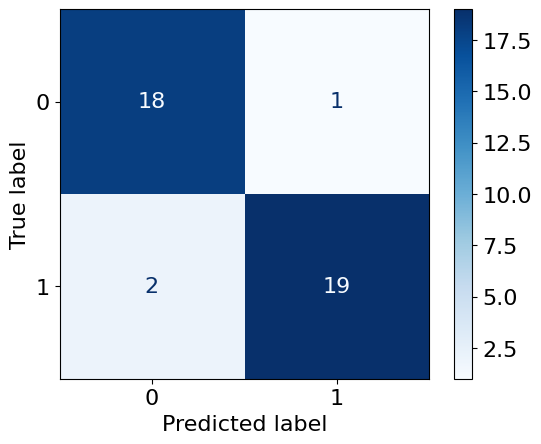

In [ ]:
# Evaluate the best model from Grid Search on the test data
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(x_test_reduced)

# Evaluate the best model on the test data
accuracyCV = accuracy_score(y_test, y_pred_best)
print(f'SVM Accuracy on the test set with best model: {accuracyCV:.2f}')

# Classification report
class_report = classification_report(y_test, y_pred_best)
print("SVM Classification Report:")
print(class_report)

# Confusion matrix
con_matrix = metrics.confusion_matrix(y_test, y_pred_best)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = con_matrix)
plt.rcParams.update({'font.size': 16}) # Increase font size
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues')  # Set the color scheme to 'Blues'
plt.show()

In [ ]:
import joblib
joblib.dump(best_model, '/content/drive/MyDrive/my_dataset/model/best_svm_model.pkl')

['/content/drive/MyDrive/my_dataset/model/best_svm_model.pkl']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize KNN
knn = KNeighborsClassifier()

# Perform 5-fold cross-validation to evaluate KNN
cvfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_knn = cross_val_score(knn, x_train_reduced, y_train, cv=cvfolds)

# Print the cross-validation scores and average
print("KNN Cross-validation scores:", cv_scores_knn)
print("Average KNN Cross-validation score:", np.mean(cv_scores_knn))

KNN Cross-validation scores: [0.625   0.78125 0.625   0.78125 0.96875]
Average KNN Cross-validation score: 0.75625


In [ ]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Set up GridSearchCV for KNN
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=cvfolds, scoring='recall')

# Fit the model to the training data
grid_search_knn.fit(x_train_reduced, y_train)

# Retrieve the best model and parameters
best_knn = grid_search_knn.best_estimator_
print(f"Best Parameters for KNN: {grid_search_knn.best_params_}")
print(f"Best Cross-Validation Score for KNN: {grid_search_knn.best_score_}")

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Cross-Validation Score for KNN: 0.8


In [ ]:
### print classification report for train data
y_pred_train = grid_search_knn.predict(x_train_reduced)
class_report_train = classification_report(y_train, y_pred_train)
print("Train Classification Report:")
print(class_report_train)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        81
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



KNN Accuracy on the test set: 0.90
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        19
         1.0       0.90      0.90      0.90        21

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



<Figure size 1000x800 with 0 Axes>

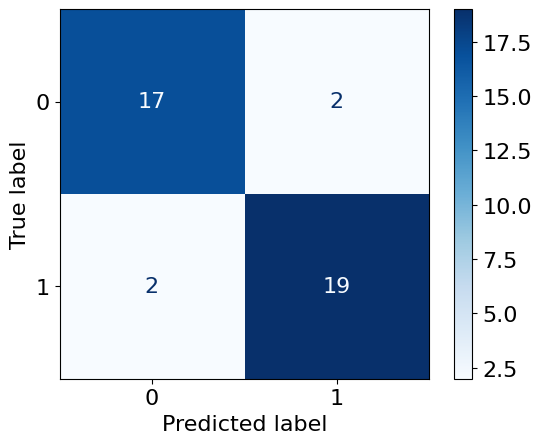

In [ ]:
# Predict on the test set using the best KNN model
y_pred_knn = best_knn.predict(x_test_reduced)

# Evaluate the KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy on the test set: {accuracy_knn:.2f}')

# Classification report
class_report_knn = classification_report(y_test, y_pred_knn)
print("KNN Classification Report:")
print(class_report_knn)

# Confusion matrix
con_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display_knn = metrics.ConfusionMatrixDisplay(confusion_matrix=con_matrix_knn)
plt.figure(figsize=(10, 8))
cm_display_knn.plot(cmap='Blues')
plt.show()


In [ ]:
import joblib
joblib.dump(best_model, '/content/drive/MyDrive/my_dataset/model/best_KNN_model.pkl')

['/content/drive/MyDrive/my_dataset/model/best_KNN_model.pkl']

Ensemble Accuracy on the test set: 0.93
Ensemble Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93        19
         1.0       1.00      0.86      0.92        21

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.94      0.93      0.92        40



<Figure size 1000x800 with 0 Axes>

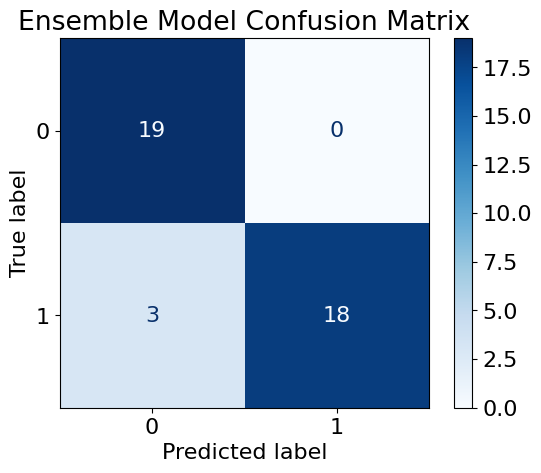

In [ ]:
# Import necessary libraries
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay

ensemble_model = VotingClassifier(
    estimators=[
        ('svm', best_svm),  # SVM with the best parameters from GridSearchCV
        ('knn', best_knn)   # KNN with the best parameters
    ],
    voting='soft',  # Use probabilities for soft voting
    weights=[2, 1]  # Assign higher weight to SVM
)

# Fit the ensemble model on the training data
ensemble_model.fit(x_train_reduced, y_train)

# Predict on the test data
y_pred_ensemble = ensemble_model.predict(x_test_reduced)

# Step 5: Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy on the test set: {accuracy_ensemble:.2f}")

# Classification report
class_report_ensemble = classification_report(y_test, y_pred_ensemble)
print("Ensemble Classification Report:")
print(class_report_ensemble)

# Confusion matrix
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ensemble)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues')
plt.title("Ensemble Model Confusion Matrix")
plt.show()

In [ ]:
from joblib import dump
dump(ensemble_model, '/content/drive/MyDrive/my_dataset/model/ensemble_model.joblib')

['/content/drive/MyDrive/my_dataset/model/ensemble_model.joblib']